### Momentum Analytics Revisited: A More Robust Approach to Quantifying how "Hot" is an NBA Team
---
*Kiran Krishnamurthi*

*December 2022*

I'm excited to share the second version of my momentum model! I've been away from basketball analytics over the past eight months, but the time away has been filled with opportunities that have allow me to create an improved second version. To start, I'd like to say thanks to all the friends and mentors who gave me insights and ideas into how I could make this model more robust to capture other important features in winning. Moreover, I've had the chance to actually see the validity in my results given that I posted the first iteration back in April 2022 looking ahead towards the NBA post-season. Finally, I've had the opportunity to really improve in my Python skills thanks to opportunities I've had working at Uber this summer and in quantitative investment research and trading this fall. Graduating this semester made life quite hectic and I missed the chance to come back to this project before the NBA regular-season started, but I'm grateful to be able to revisit it now and show the second iteration.

Below are the finalized equations I've created to model "momenutm", the attempt to capture and quantify how well a team has performed over the course of the season before the playoffs. The rest of the paper explains all the terms and how I transitioned from the first iteration to the second. 

**Single Game Momentum (Marginal Momentum)**
$$ m_g = \left[ \theta_g + \left( \Delta P_g  \times \omega_{opp,g} \right) \right] + \left[ \zeta_{g} \times \gamma (g) \times \lambda_{g} \right] $$

**Total Momentum (Aggregate Momentum)**
$$ M_{(1, \space g)} = \sum^{G}_{g = 1} m_g = \sum^{G}_{g = 1} \left[ \theta_g + \left( \Delta P_g  \times \omega_{opp,g} \right) \right] + \left[ \zeta_{g} \times \gamma (g) \times \lambda_{g} \right] $$


##### Table of Contents: 

1. [Variable Notation](#variablenotation)
2. [Overview of Momentum Version 2](#versiontwo)
3. [Results in Action](#results)
4. [Fourier Analysis Applied to Constructing a Dynamic Game Smoothing Parameter](#gamma)
5. [Strength of Opponent in a Win or Loss](#omega)
6. [Accounting for the Shooting Green-Light with a Three-Point Shooting Parameter](#theta)
7. [Scaling the Point Differential](#delta)
8. [Inflating Road Wins and Deflating Home Losses](#lambda)
9. [Differentiating Winning vs. Losing Streaks](#zeta)

##### Variable Notation <a name="variablenotation"></a>

| Variable | Meaning |
|:--------:|:--------|
| $m_g$ | The single game momentum, also seen as marginal momentum from a game |
| $M_{(1, g)}$ | The cumulative or total momentum for a team up until game $g$, where g can be any value from 1 through 82 |
| $\theta_g$ | The parameter representing how well a team shot the ball from the three-point line in a game |
| $TPM_g$ | The total number of three-pointers made by a team in a game | 
| $\phi_g$ | The three-point field goal percentage for a team in a game |
| $\Delta P_g$ | The point differential for a team from a game, measured by difference in points scored and conceded | 
| $P_{Tm, g}$ | The total points scored by the team in a game | 
| $P_{Opp, g}$ | The total points scored by the opponent in a game |
| $\omega_{opp, g}$ | The parameter used to account for the strength of an opponent |
| $\omega_L$ | The omega parameter used in the case where a team loses the game |
| $\omega_W$ | The omega parameter used in the case where a team wins the game |
| $\rho_g$ | The percent of total games won by the opponent at game g in the nba-regular season (i.e., opponent winning percentage) |
| $\zeta_g$ | The parameter that accounts for the impact of a winning or losing streak in the momentum model |
| $\textnormal{sgn} \space x$ | The sign of x, where x represents the point differential for a giving game g |
| $S_g$ | The number of the game within the current streak, e.g. win number 5 in a row. |
| $\gamma (g)$ | The parameter which acts as a function of the game number in the regular season, used to weight the importance of when a game is played | 
| $\lambda_{g}$ | The parameter used to inflate the value of road wins and home losses | 

### Overview of Momentum Version 2 <a name="versiontwo"></a>
---
At the end of the 2021-2022 NBA regular season I posted about a metric I had worked on called *momentum*. Momentum was my attempt to help quantify or capture the value of consistent good (bad) performances from a team over time. Obviously, there are traditional or more conventional ways of understanding which team is the "best" in the conference or across the league, but existing methods like record or conference ranking don't take into account more situational or contextual factors that I seek to capture with the momentum metric. 

The first iteration of this metric came in April 2022, with the goal of creating some quantification to represent a team's performance throughout the season. This first model revolved around three terms: the number of the game in the season, the team point differential for each game, and the number of consecutive wins or losses in a row at each game played. This metric can be decomposed into a game level calculation of momentum and a running sum of total momentum across a season, which is just the sum of each individual game level momentum. If interested, my paper on the first version can be found [here.](https://rpubs.com/kckrishn/nba_2021_2022_momentum_analysis) 

***Single Game Momentum (Marginal Momentum)***
$$ m_g = \left[ \theta_g + \left( \Delta P_g  \times \omega_{opp,g} \right) \right] + \left[ \zeta_{g} \times \gamma (g) \times \lambda_{g} \right] $$

***Total Momentum (Aggregate Momentum)***
$$ M_{(1, \space g)} = \sum^{G}_{g = 1} m_g = \sum^{G}_{g = 1} \left[ \theta_g + \left( \Delta P_g  \times \omega_{opp,g} \right) \right] + \left[ \zeta_{g} \times \gamma (g) \times \lambda_{g} \right] $$

The first version of the momentum model came to me after thinking about how my Cleveland Cavaliers were the second seed in the east at one point and sadly failed to make the final eight for the post-season. How could a team achieve such a peak, relatively deep into the season, but still walk away without anything to show for that height. It would be a stretch to say that conventional measures fail to explain their performance, but just saying the team lost more games than they won coming off of that peak doesn't tell the full story. 

That's what brought me to create a slightly more complex model compared to just the conference rankings, capturing wins and losses with added details focused on winning/losing streaks, margins of victory/defeat, and win/loss timing. These three aspects first jumped out to me as the elements of a game that might stick with a team after the fact. Now, in this second iteration I'm happy to be able to include a handful of additional, more complex, elements that provide greater detail on other important game aspects which have cascading impacts on a team into the future. 

I explain all the parameters in greater detail in their respective sections, so for the overview I provide a high-level understanding of what goes into Momentum Version 2 and a justification for why I think the new parameters are important. I decided to keep all the original model inputs but made adjustments to the parameters to better fit them within the bounds of this second iteration. 

**$\gamma (g) \rightarrow$** is a dynamic time-varying parameter which adjusts as the season progresses to appropriately weight the value of a game. The dynamic weighting is important as my hypothesis is that wins at certain points in the season (i.e., the first handful of games and the final stretch of games) are the most important to defining a teams success. The middle of the season isn't a total wash but the game effects are less sticky during this part of the season on a team's ability to make a deep playoff push. 

**$\zeta_g \rightarrow$** is the parameter accounting for the win or loss streak. Originally, this value was only positive and represented the length of the streak at game $g$. Now, this parameter has direction and is meant to add to the positive (negative) effects of continued winning (losing). 

**$\Delta P_g \rightarrow$** represents the point differential. This is still the same parameter in concept, except the values have been scaled based on the aveage points per game for a team at game $g$ in the regular season. Scaling the value was important to balance out the impacts of all the different parameters. Common margins of victory could still be up to 10x greater than values of other parameters and therefore this would overweight the importance of the point spread. 

**$\omega_{opp, \space g} \rightarrow$** This begins the addition of new parameters to the model. Omega is used to account for the strength of the opponent in game $g$. This parameter could take on two values, one for the game where a team wins a game and another in the case of a loss. In a winning scenario, the parameter positively with the winning percentage of the opponent. For losses, the parameter shrinks as an opponents winning percentage increases. The movement of the parameter is justified under the hypothesis that a win against a good team should have greater morale boost for a team. Similarly, a loss to a bad team could have a outsized detriment to a team's morale compared to playing a good team. 

**$\theta_g \rightarrow$** This parameter captures how well a team shot the three-ball in a given game $g$. I wanted to include a shooting parameter to the model since shooting has such a significant impact on player & team confidence. If a team shot the lights out and still lost the game, chances are they're not going to hesitate to shoot going forward. However, if a team shoots poorly and loses then it's a different story. Theta is included to provide more in-game details on a team's performance to better capture the details of the win or loss. I chose to measure the team's strength in shooting the three-ball instead of just their field goal percentage since the three-pointer is a key part of a high-powered offense in today's game and also has a powerful impact on a team's confidence. 

**$\lambda_g \rightarrow$** The final parameter is included to adjust for two special game outcomes: the road win and the home loss. Lambda is a simple parameter, taking on the value of 1 or 1.25. It assumes the latter in the case of a road win or a home loss, as I assume these two game outcomes to have a greater impact on a team's momentum. Road wins should have a greater boost given that a team has to travel to another arena and play in front of the opposing team's fans. In constrast, a home loss should have a more determintal impact on a team's momentum given that they're supposed to have the upper hand, get to play in front of their own fans, and don't have to travel at all for the game. Lambda only takes on positive values since it is multiplied to the $\zeta_g$ parameter which accounts for the direction (i.e., wins versus losses). 

The model can be decomposed into two components, being the left and right term on the sides of the + sign. 

$$ m_g = \underbrace{\left[ \theta_g + \left( \Delta P_g  \times \omega_{opp,g} \right) \right]}_{\textnormal{In-game Details}} + \underbrace{\left( \zeta_{g} \times \gamma (g) \times \lambda_{g} \right)}_{\textnormal{Game Timing Details}} $$

I constructed the model as displayed above according to the following logic. I decided to split the model into two terms since there are multiple directional variables. In this model, both $\Delta P_g$ and $\zeta_g$ will be negative if a team loses a game. Multiplying both of these variables together would create positive momentum for the sitation which would not be correct. Therefore, splitting up the two terms allows for the inclusion of multiple directional variables. 

The left term of the equation is designed to account for more in-game details. I multiply the margin of victory (defeat) against the opponent strength parameter to adjust the margin according to how good (bad) the opposing team was. I then added this to the shooting parameter to potentially soften the blow of a loss in the event that a team shot well. A more general understanding would be that there are two in-game details that can stick with a team's momentum as they move forward into the season: the efficiency or quality of their offense and their offensive output, measured by $\theta_g$ and $\Delta P_g$ in this term. 

The right term of the equation captures more time dependent characteristecs of a the outcome of a given game. If a team is deep in a winning (losing) streak at an important (unimportant) part of the season, these factors should compound with one another to impact momentum. Additionally, if the team wins (loses) in a setting where they're not expected (expected) to have performed that well, then this should also compound with the situational factors.

Borrowing from the same example used in the first paper, I'll explain how this model works by using the Dallas Mavericks and their 112 to 105 victory over the Los Angeles Clippers from February 10th, 2022. Dallas won this game with a 7-point margin of victory, shooting 33% from the field making 13 three-pointers. The Clippers at this point had a winning percentage of 48.21%. This was Dallas's 56th game of the season and their fourth win in a row, beating the Clippers at home. If all these details are then put into the model, we see that this game had a marginal momentum impact of +36.17 for the Mavericks, making their aggregate momentum for the year at that point in time +583.76. 

### Momentum Version 2 Results <a name="results"></a>
---

The million dollar question is then how does this model perform in comparison to the first model? It helps that the 2021-2022 NBA post-season has already concluded, as now we can retroactively evaluate the performance of the first version of momentum. A quick check of how the model performed compared to reality doesn't produce many surprises for the Eastern conference, but is a bit less consistent for the Western conference. In the East, the model had Boston as the unquestionable favorate to make it out of the conference, but in hindsight their path was a lot more difficult than suggested given their back-to-back 7-game series against Milwaukee and Miami. More minor errors show that Toronto had greater momentum than Philadelphia despite falling in a 6-game series to the 76ers. 

In the West, the model predicted Phoenix to dominate the conference. We all know how that turned out (lets go Luka), but their collapse in game seven of that series was unexpected to say the least. However, the model doesn't seem to think too highly of the Warriors, the eventual 2021-2022 NBA champions. It scores them accordingly with their 3rd-seed spot heading into the playoffs, but teams like the Timberwolves and the Mavericks have comparably high momentum. 

Below are the visualized results for how this model would've performed if applied to the 2021-2022 NBA regular season. 

![Eastern Conference Playoff Teams](ec_playoff_momentum.png)

The results for the Eastern Conference aren't too shocking, but they're a lot more inline with reality when compared to the original version. One of the bigger differences in these results is that while Boston is still the conference momentum leader, their advantage isn't as dominant as that produced in version one. In the case of Philidelphia and Toronto, the model still suggests that Toronto has a momentum advantage but the gap is much closer. The rest of the results follow the actual breakdown of Eastern Conference playoff play. If one was to extraplote on the results produced in this graph, it would be to go back and look at the amount of times two curves cross over to really study the advantage one team has over another. For example, at the end of the season Miami finished with a slight momentum advantage over Milwaukee. But, their two curves cross over a handful of times during the season which suggests they're much more similar than results might indicate. 

![Western Conference Playoff Teams](wc_playoff_momentum.png)

Western conference results are also closer to reality in this version compared to the prior. Phoenix's lead is still evident when compared to all other teams, but on paper there isn't anything too alarming to dispute their momentum advantage. This version of the model does a lot more justice to Golden State, leaving them with the 3rd highest momentum in the conference and just under Memphis who has the 2nd highest. Memphis comfortably held the 2nd seed in the conference, but Golden State took them down in a 6-game series in the Western Conference semi-final. Memphis was missing their star player (Ja Morant), but perhaps Golden State was a lot closer of a matchup than end of season standings might've suggested. This is a tough case to justify the model on, however, since Golden State is loaded with veteran talent and playoff experience, two of the most important roster characteristecs come the post-season. 

Version two doesn't inflate the performance of the Timberwolves anywhere near as high as did version 1. They're a good team and took two games off the Grizzlies, but they're not a top three team in the Western Conference for aggregate momentum. However, a team that punched above its weight in the playoffs but didn't score well in both iterations is the Pelicans. In both cases, they produce the lowest aggregate momentum out of all Western Conference teams, but still managed to take two games off the conference leader. 


### Fourier Analysis Applied to Smoothing Parameter Construction <a name="gamma"></a>

The first iteration of this model approached the value of wins and losses as increasing linearly. The original parameter $\gamma$ increased by one for each game into the 82-game long NBA regular season. While simple, this approach was effective in capturing my original intention which was to show that wins and losses matter more to a team's momentum later on into the regular season than they do earlier. Nonetheless, this model might suffer from oversimplification under the assumption that holding all else equal, momentum should scale linearly as the number of the game out of the 82 game regular season increases. 

A second and more robust iteration seeks to support the hypothesis that the value of a win or loss does not scale linearly throughout the NBA regular season. Moreover, even if the value of a win or loss is not to scale linearly but in some other fashion, there is an argument to be made that the value of a win or loss at game $g$ does not necessarily have to be greater than that of the same outcome at any time $g-1$ in the past. Put simply, the number of a game in the regular season has a varying degree of impact on a teams momentum depending on when during the season the game occurs. The basis for this hypothesis is rooted in the following logic. To start, games at the end of the NBA season have a greater impact than other games, especially for those teams that are in bunched up rankings to crack the playoffs or fighting for seeding. Additionally, games at the beginning of the season might have a greater impact than other games given that this is when a team can really set the tone and get started on the right footing. On the other hand, there's most likely a mid-season lull around the all-star break, where winning is still important but doesn't have the same boost to a team's morale or confidence when compared to the early and late stages of an NBA season. 

With all this in mind, the parameter construction needs to capture the dynamics of how important the $g^{th}$ game into the NBA season is for a team's momentum. I I approached this task through the lens of fourier analysis, performing a rudimentary decomposition on the theoretical importance of different game numbers $g$ on a teams momentum with three different functions. Fourier analysis is the study of how simple trigonometric functions can be used to model or estimate more complex general functions.

#### Function 1 

Initially, I wanted to model the dynamics of a game's impact using just one function. Taking the aformentioned logic, I start by taking an 82 game NBA season and dividing it into quarters, essentially identify four points during the season where momentum might change. Since 82 isn't perfectly divisible by 4, the final values come out to 23, 41, 62, and 82. From there, we can look at an NBA season as an aggregation of periods between these points. The first period, from the start of the season to game 23 is critical for a team to get off on the right foot, with games increasing in importance up until that point. In building the model, game 23 becomes a local maxima in the smoothing parameter function. However, from there, games 23 through 41 slowly decrease in importance with games becoming less critical to a team's momentum which leads game 41 to become a local minima. Finally, the rest of the games continue to grow in importance until the end of the season, game 82, which means that the function continuously increases from 41 to 82. With all this in mind, I construct a cubic function with a derivative with roots at 23 and 41 with dynamics that follow: 

$$ f'(g) = (x - 23)(x - 41) \rightarrow x^2 - 41x + - 23x + 943 \rightarrow x^2 - 64x + 943 $$

This function is the derivative of the actual game-adjusting smoothing parameter since I'm looking to create a local maxima at 23 and a local minima at 41. Therefore, the actual smoothing parameter is the integral of this function as the derivative will have roots of zero at the local maxima and minima. Integrating the function gives us the following: 

$$ f(g) = \int_1^{82} \! x^2 - 64x + 943 \, \mathrm{d}x \rightarrow \frac{x^3}{3} - \frac{64x^2}{2} + 943x + c$$

The integral of $f'(g)$ is the final function to model the time-varying dynamics of how important the game number is on a team's momentum. However, the scaling of this function tends to disproportionately favor games later on into the season over all others, and therefore I took the log of this function to scale its impact. I also subtract 2.4 from any output of the function in order to scale it with the second term in the smoothing paramter. Thus, the finalized version of the first component to the smoothing parameter is as follows: 

$$ \gamma_{1}(g) = \log \left( \frac{g^3}{3} - \frac{64g^2}{2} + 943g \right) - 2.4 $$

#### Function 2

A second term is needed in capturing what I believe to be the true time-varying impact of a game number on a team's momentum in order to better account for amplitude between maxima and minima. The term from function 1 does discriminate in assigning value to games appropriately, but to some extent I feel the impact i not as pronounced as it should be. Additionally, the local minima at the midpoint of the season is still worth more of an impact compared to the first few games of the season which I'd argue are more important to a team to get off on the right foot. 

This is where a trigonometric function can help, and also where actual fourier analysis comes into play. The $\sin$ and $\cos$ functions both model the wavelike movement that I am looking for in constructing this parameter. The two biggest catches are the need for all y-values to remain positive and for the period to occur such that $f'(g)$ would have zeros at the desired 23rd and 41st games. This led me to start off with modeling the impact of the game number through the following function: 

$$ f(g) = 2\pi \times \frac{|g - 41|}{41} $$

This function produces a v-shaped graph where there is a nondifferentiable zero at game 41. However, this produce an output where the games at the start and end of the season are of the most importance and all other games decline in relative value. I then transitioned this function into a trigonometric function that produces the wave-like output that is needed to better capture the time-varying impact.

$$ f(g) = -\cos\left(2\pi \times \frac{|g - 41|}{41}\right) \times + 5.85 $$

The cosine function best produces the peaks and troughs that coordinate with where the importance of games should occur. I invert the function by multiplying it by negative 1 so that the value of games increases up until the zeros that I'm most concerned with (25, 41). The final addition of 5.86 to the output of the function scales this for better combination with the functions 1 and 3; the goal is to create a cohesive smoothing parameter. This leaves us the final $\gamma_{2}(g)$ equation to combine in a piecewise smoothing parameter. 

$$ \gamma_{2}(g) = -\cos\left(2\pi \times \frac{|g - 41|}{41}\right) + 5.85 $$

#### Function 3

Finally, this last function is necessary in accounting for the fact that games at the season should have the most impact on a team's momentum. For that matter, I consider wins and losses in the final quarter of the NBA season to be "sticky" on a team's morale and confidence. Late season wins can give a team that extra push necessary to battle through a first round series whereas a late season slump can be just detrimental enough to push a team out of form.

Function 3 in the piecewise function is a transformation of function 1. My initial problem with using just function 1 to model the impact of the game number $g$ in a season was the lack of variation in the amplitude of the function for all $g$ between 1 and 82, inclusive. After applying the cosine function to vary the importance of games during the mid-season stretch, I transform the original cubic function to increase the steepness of the curve from games 62 onward. This allows for the weight of games at the end of the season to be more than at any other point. But, with the use of a piecewise function I can still weight games at the beginning of the season greater than those in the middle. 

$$ \gamma_{3}(g) = \sqrt{\left[ \log \left( \frac{g^3}{3} - \frac{64g^2}{2} + 943g \right) - 2.4 \right]^{\left(1.2 + \frac{g}{82}\right)}} $$

$$ \gamma_{3}(g) = \sqrt{\left[\gamma_{1}(g)\right]^{\left( 1.2 + \frac{g}{82} \right) }} $$

#### Smoothing Parameter

These two functions $\gamma_1(g)$ and $\gamma_2(g)$ are then combined to create the piecewise function which I use to model the time-varying impact of a game on a team's momentum. The finalized smoothing parameter is labeled as $\gamma$ and it is a function dependent on the input variable $(g)$. One important callout is the adjustment of where I initially wanted to place the zeros. In the function below you can see the conditions to switch between the different $\gamma$ are at 25 and 61, not at the initial 23 like I had imagined. The derivative of function 1 approaches zero in the range where the derivative of function 2 also approaches zero. The overlap here provides some flexibility in where the switch occurs, and the smoothest transition happens when $g = 25$.

$$ \gamma(g) =   
    \left\{
        \begin{array}{ll}
            \gamma_{1}(g) = \log \left( \frac{g^3}{3} - \frac{64g^2}{2} + 943g \right) - 2.4 &: \space 01 \leq g < 25 \\
            \\
            \gamma_{2}(g) = -\cos \left( 2\pi \times \frac{|g - 41|}{41} \right) + 5.85 &: \space 25 \leq g \leq 61 \\
            \\
            \gamma_{3}(g) = \sqrt{\left[ \log \left( \frac{g^3}{3} - \frac{64g^2}{2} + 943g \right) - 2.4 \right]^{\left(1.2 + \frac{g}{82}\right)}} &: \space 61 < g \leq 82\\
        \end{array} 
    \right.  
$$



![Smoothing Parameter Visualized](gamma_visualized.png)

### Win-Loss Weighting on the Strength of an Opponent <a name="omega"></a>
---
Not all wins are created equal. To borrow from college basketball, a 16-seed University of Marlyland Baltimore College (UMBC) beating a 1-seed University of Virginia (UVA) is ***not*** the same if the 1-seed UVA were to have defeated the 16-seed UMBC. March Madness might not be the best example to borrow from since the tournament is single elimination, but the concept of a much better team beating a worse team and vice versa is something generalizable across all sports. For the NBA, if you are a team already at the top of your conference standings and you blow-out a team that's tanking for draft picks, that win should not count as much towards your moment compared to if you were a team that's fighting for a play-off spot and manages to take out a current top-3 seed. 

All this goes to say that the fault of the original model lies in its simplicity in failing to incorporate strength of opponent in a win or loss. This is a crucial piece of information to add. First, it gives us another degree of differentiation in performances as now we can say certain wins and losses should have greater impact based upon the opponent. But secondly, it provides an opportunity for teams to interact with one another directly in their momentum. The prior model had no unique component where the variable was based on the opponent, everything was game dependent. Now, having an opponent specific term allows us to see how momentum changes with interactions with other vying contenders.

$$ \omega_{opp, g} = 
    \left\{
        \begin{array}{ll}
            \omega_L = \log \left( \frac{1}{max(\rho_g, \space .01)} \right) + 1 & \Delta P_g < 0 \\
            \\
            \omega_W = \log \left( \frac{1}{1 - min(\rho_g, \space .99)} \right) + 1 & \Delta P_g > 0 \\
        \end{array} 
    \right.  
$$

This parameter is much simpler in comparison to the dynamic game-smoothing parameter. The main input into this parameter is represented by the character $\rho_g$ which is just the opponents win percentage at game $g$. The first of the two functions in the piecewise equation above is in the case where a team loses. The equation is bounded between 1 and 6, where teams with worse records will produce higher values in the model. This is important insofar as the condition for the use of this part of the piecewise equation is a lose (represented by the negative point differential). This allows for loses to teams with worse records to have a greater negative impact on a teams momentum compared to losing to a top ranked team. 

The second of the two equations operates in a very similar manner, just with the opposite intention. By taking the difference between 1 and the team's winning percentage, the denominator becomes smaller for the better record a team might have. Outputs for this function for all $g$ between 1 and 82 are also bounded between 1 and 6 but scale in the opposite direction where a better record produces a higher output. This is then multiplied in cases of positive point differentials which represent wins. A win against a good team therefore has a greater and more impactful effect on a team's momentum compared to beatdowns on bad teams. 

The one main drawback in applying this parameter is that it will be noisy, especially at the start of the season. When records are made up of only a handful of games win-percentages change rapidly and dramatically. Additionally, when a team has one 100% of their games, this warrants the need for the min and max arguments in the model construction. Having a value of 100% for a win-percentage will produce infinite values in parameter construction so the maximization constraint is added to the denominator of the second function. The maximization constraint is applied in the first function as cases where a team has no wins (i.e., a win percentage of 0) would produced undefined $\omega_W$.

### Accounting for the Shooting Green-Light with a Three-Point Parameter <a name="theta"></a>
---

Momentum and confidence are not synonyms, but the former does seek to quantify the later in some aspects. In my attempt to improve the comprehension of this model, I'm looking to add in features that better capture aspects of confidence asies from the actual outcome of the game. For that matter, I come to question of **are there elements of in-game play that matter for momentum independent of the result of the game?** 

One of the more obvious proxies for confidence that one could capture from the box-score would be a players shooting. The hot-hand fallacy in shooting comes from the idea that a player takes more shots when they see their prior attempts go down; it's a positive feedback loop. It can be safely argued that taking more shots and making them are elements of a winning basketball team. A shooter shoots. Those who don't even want to take shots in the first place are putting themselves at a disadvantage relative to other players by limiting their opportunities to quite literally get buckets. If a whole team shoots the ball poorly on a given night, are they going to suffer from the safe blow to their confidence moving forward? Or, if a team shoots the ball really well but still loses, will their confidence take less of a hit than it would've if they shot the ball poorly and lost? These are the questions that led me to adding the three-point shooting parameter into the model. 

$$ \theta_g = \frac{TPM_g}{1 - \phi_g} $$

The value of $\theta$ is dependent on two inputs from the box-score, the number of three-pointers made by a team ($TPM_g$) and the teams three-point shooting percentage ($\phi_g$) which is just total makes over total attempts. By taking the difference from 1 and putting this in the denominator, we're able to inflate the value of $\theta$ for teams that shoot the ball really well. Putting the total number of makes in the numerator also allows this value to scale with simply making more threes. This allows the value of $\theta$ to reward both efficiency *and* volume. In that vein, I constructed this parameter with the intent of avoiding inflating shooting performances that are highly efficient but low in volume. 

![Distribution of Theta in Wins and Losses](theta_distribution.png)


### Scaling the Point Differential <a name="delta"></a>
---

The point differential is a simple but crucial metric to evaluating any win or loss. The larger the spread, the more "dominant" a victory is considered to be. It's a simple enough concept to include the raw value of points scored minus points conceded in the model. But after adjusting the complementing parameters, the point differential has an oversided impact on team momentum. A 20-point win could be considered a blowout, but in some cases this factor will be 2-3 times larger than any other parameter in the model. If terms are to be multiplied together, then this will distort the final value for $m$ and $M$. 

My idea for scaling this parameter would be to look at the size of victory (defeat) relative to an average NBA regular-season scoreline. Simple enough, the adjusted point differential parameter takes the point differential at game $g$ and divides it by the base-10 log of the rolling average for total points scored in an game. 

$$ \Delta P_g = (P_{Tm, g} - P_{Opp, g}) \div \log_{10} \left( \frac{ \sum^{G}_{g = 1} \frac{ P_{Tm, g} + P_{Opp, g} }{2}}{G} \right) $$

This scaled point differential still has a mean of 0 since it preserves the fact that for every positive point differential, there is the exact same value except negative for the losing team. The denominator in this model is dynamic and adjusts as the average team points-per-game increases throughout the regular season. Having a denominator for the difference helps relativize a margin of victory or defeat based upon league averages. 

### Inflating Road Wins and Deflating Home Losses <a name="lambda"></a>
---

One term that I didn't initially think to include but now realized has a potential incremental impact on a teams momentum would be where a win or loss occurs. A win is a win, but in the spirit of not all wins being created equal, a road win is considered to be more difficult than a home win. Similarly, on the other side of the coin is a loss. If a team has a better chance of winning if they're playing at home in front of their own fans, a loss at home then should be more demoralizing compared to losing on the road. The expectations are not in their favor on the road but they are at home (in theory). 

To capture this effect, I added the $\lambda$ term into the model which is a binary coefficient, taking on a value greater than 1 in the case of the two more extreme events (road wins and home losses). 

$$ \lambda_{g} = 
    \left\{
        \begin{array}{ll}
            \lambda_{A,W} = 1.25 & Loc = A, \space \space \Delta P_g > 0 \\
            \lambda_{H,L} = 1.25 & Loc = H, \space \space \Delta P_g < 0 \\
            \lambda_{H,W} = 1    & Loc = H, \space \space \Delta P_g > 0 \\
            \lambda_{A,L} = 1    & Loc = A, \space \space \Delta P_g < 0 \\
        \end{array} 
    \right.  
$$

### Differentiating Winning vs. Losing Streaks <a name="zeta"></a>
---

Version 1 of the momentum model controlled for the direction of a team's momentum through the point differential ($\Delta P_g$). This worked in a parsimonious setting where we only had three terms, but in this case where there are other situational factors that positively or negatively impact momentum, adding another way to control for the direction seemed necessary. Incorporating this into the win or loss streak made the most sense given that a team can either ascend on a massive win streak (keep the direction positive) or spiral out of control on a massive losing streak (keep the direction negative). 

$$ \textnormal{sgn} \space x_g := 
    \left\{
        \begin{array}{ll}
            -1 & \space \iff \space \Delta P_g < 0 \\
            \\
            1 & \space \iff \space \Delta P_g > 0 \\
        \end{array} 
    \right.  
$$

$$ \zeta_g = \textnormal{sgn} \space x_g \times S_g $$

The first function here is the sign function. This just takes the sign of the value of the point differential, which we use a proxy for a game won or lost. If a team loses, we treat the sign as negative and if they win then it's treated as positive. The second term is where we control for the direction of the streak. The term $S_g$ represents the consecutive game number in the streak. Multiplying this by the sign of x at game g ($\textnormal{sgn} \space x_g$) differentiates winning streaks from losing streaks through increasingly positive or negative values.

In [509]:
# Load Libraries #

import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import os

# Set Directory # 

wd = '/Users/kirankrishnamurthi/Library/Mobile Documents/com~apple~CloudDocs/Data Science/Projects/NBA End of Season Streak Project'

os.chdir(wd)

#-- Suppress Warnings
import warnings
warnings.filterwarnings("ignore")

# Load in Data # 
data = pd.read_csv('nba_2021_2022_game_logs.csv', parse_dates = ['Date']).sort_values(by = 'Date')



In [510]:
#-- Column Initialization & Cleanup --#

#-- Preserve Indexing Columns
data['Game'] = data['G']
data['Team'] = data['gamelog_team']

#-- Set the Index
data = data.set_index(['Game', 'Team'])

#-- Create Gamelog Primary Key
data['primary_key'] = data['gamelog_team'] + "_" + data['G'].map(str) + "_" + data['Opp_Team'] + '_' + (data.groupby('Opp_Team').cumcount() + 1).map(str)

#-- Reset Home and Away Column
data['H_A'] = np.where(data['H_A'] == '@', 'AWAY', 'HOME')

#-- Create an array of just the teams
teams_array = data['gamelog_team'].unique()

#-- Creating a binary win / loss column 
data['win_binary'] = np.where(data['W_L'] == 'W', 1, 0)

#-- Create winning accumulation and percentage change columns
data['win_total'] = data.groupby(by = 'gamelog_team').win_binary.cumsum()
data['win_pct'] = (data['win_total'] / data['G']) 

#-- Create a primary key for the matchup with the opponent name and game ID
data['opp_win_pct_pkey'] = data['G'].map(str) + '_' + data['Opp_Team']

#-- Output Check
data.head()

Rk  G       Date   H_A Opp_Team W_L   Tm  Opp  FG  FGA  ...  \
Game Team                                                          ...   
1    BRK    1  1 2021-10-19  AWAY      MIL   L  104  127  37   84  ...   
     MIL    1  1 2021-10-19  HOME      BRK   W  127  104  48  105  ...   
     LAL    1  1 2021-10-19  HOME      GSW   L  114  121  45   95  ...   
     GSW    1  1 2021-10-19  AWAY      LAL   W  121  114  41   93  ...   
     PHI    1  1 2021-10-20  AWAY      NOP   W  117   97  44   85  ...   

           Opp_BLK  Opp_TOV  Opp_PF  nba_season  gamelog_team  primary_key  \
Game Team                                                                    
1    BRK         9        7      19        2022           BRK  BRK_1_MIL_1   
     MIL         9       12      17        2022           MIL  MIL_1_BRK_1   
     LAL         2       17      18        2022           LAL  LAL_1_GSW_1   
     GSW         4       17      25        2022           GSW  GSW_1_LAL_1   
     PHI         6       13      16        2022           PHI  PHI_1_NOP_1   

           win_binary  win_total  win_pct  opp_win_pct_pkey  
Game Team                                                    
1    BRK            0          0      0.0             1_MIL  
     MIL            1          1      1.0             1_BRK  
     LAL            0          0      0.0             1_GSW  
     GSW            1          1      1.0             1_LAL  
     PHI            1          1      1.0             1_NOP  

[5 rows x 48 columns]

In [511]:
#-- Create a DataFrame of teams winning percentage on a game by game basis

data_win_pct = pd.pivot_table(data = data,
                index = ['G', 'gamelog_team'],
                values = 'win_pct',
                aggfunc = np.sum).reset_index().sort_values(by = ['gamelog_team', 'G'])

data_win_pct['opp_win_pct_pkey'] = data_win_pct['G'].map(str) + "_" + data_win_pct['gamelog_team']

data_win_pct.set_index('opp_win_pct_pkey', inplace = True)
data_win_pct['opp_win_pct'] = data_win_pct['win_pct']

data_win_pct.tail(10)

,G,gamelog_team,win_pct,opp_win_pct
opp_win_pct_pkey,,,,
73_WAS,73,WAS,0.424658,0.424658
74_WAS,74,WAS,0.432432,0.432432
75_WAS,75,WAS,0.426667,0.426667
76_WAS,76,WAS,0.434211,0.434211
77_WAS,77,WAS,0.441558,0.441558
78_WAS,78,WAS,0.435897,0.435897
79_WAS,79,WAS,0.443038,0.443038
80_WAS,80,WAS,0.437500,0.437500
81_WAS,81,WAS,0.432099,0.432099


In [512]:
#-- Merge all data together

data = data.join(data_win_pct['opp_win_pct'], on = 'opp_win_pct_pkey', how = 'left', lsuffix='_team', rsuffix='_opponent')

data[['primary_key', 'opp_win_pct_pkey', 'win_pct', 'opp_win_pct']].tail(10)

primary_key opp_win_pct_pkey   win_pct  opp_win_pct
Game Team                                                       
82   UTA   UTA_82_POR_82           82_POR  0.597561     0.329268
     DEN   DEN_82_LAL_82           82_LAL  0.585366     0.402439
     MIN   MIN_82_CHI_82           82_CHI  0.560976     0.560976
     NOP   NOP_82_GSW_82           82_GSW  0.439024     0.646341
     LAC   LAC_82_OKC_82           82_OKC  0.512195     0.292683
     SAS   SAS_82_DAL_82           82_DAL  0.414634     0.634146
     LAL   LAL_82_DEN_82           82_DEN  0.402439     0.585366
     SAC   SAC_82_PHO_82           82_PHO  0.365854     0.780488
     DET   DET_82_PHI_82           82_PHI  0.280488     0.621951
     HOU   HOU_82_ATL_82           82_ATL  0.243902     0.524390

In [513]:
def not_equal(inser):
    inser_shifted = inser.shift(periods = 1)
    outser = inser.ne(inser_shifted)
    return outser

In [514]:
#-- GroupBy Operations for Streaks

data['win_binary_shift'] = data.groupby('Team').win_binary.shift(periods = 1)
data['start_of_streak'] = data['win_binary'].groupby('Team').apply(not_equal)
data['streak_id'] = data['start_of_streak'].groupby('Team').cumsum()
data['streak_counter'] = data.groupby(['Team', 'streak_id']).cumcount() + 1

data.loc[data.index.get_level_values('Team') == 'BRK', ['win_binary', 'start_of_streak', 'streak_id', 'streak_counter']]

,,win_binary,start_of_streak,streak_id,streak_counter
Game,Team,,,,
1,BRK,0,True,1,1
2,BRK,1,True,2,1
3,BRK,0,True,3,1
4,BRK,1,True,4,1
5,BRK,0,True,5,1
...,...,...,...,...,...
78,BRK,0,False,41,2
79,BRK,1,True,42,1
80,BRK,1,False,42,2


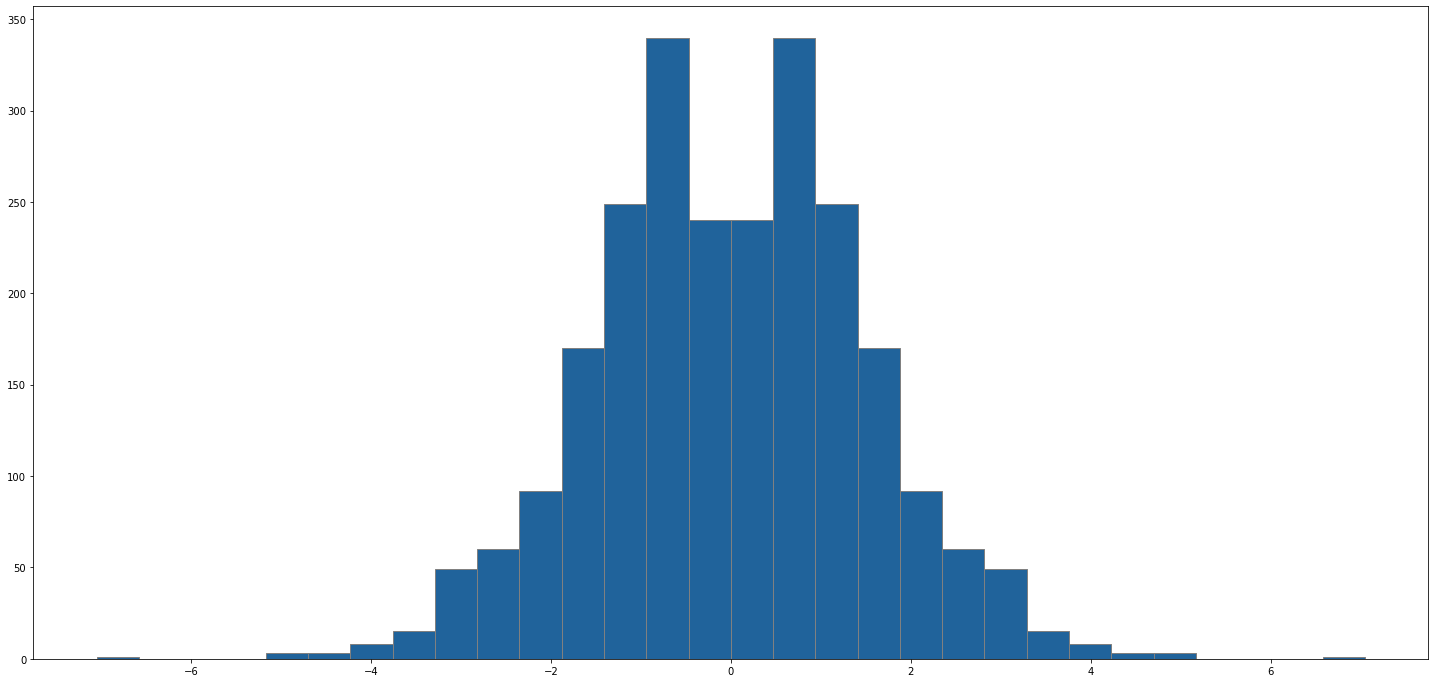

In [738]:
#-- Visualize Delta P 

delta_p_plotting = data.Delta_P

plt.figure(figsize = (25, 12), edgecolor = 'black')

plt.hist(, alpha = 1, ec = 'grey', bins = 30, color = color_palette[1])

plt.xticks(np.arange(np.min(data.Delta_P) - 2, np.max(data.Delta_P) + 2, step = 2))

plt.show()

In [858]:
#---- Building Momentum -----# 

#- Need to build the following parameters
    #- Theta = 3PM / (1 - 3P%)
    #- Delta P = Tm - Opp
    #- Zeta = Streak Counter
    #- Gamma = Function on G
    #- Omega Win = log(1 / ( 1 - np.minimum(win_pct_y, .99)) ) + 1
    #- Omega Loss = log(1 / np.minimum(win_pct_y, .99)) + 1

data['Theta'] = np.sqrt( data['3P'] / (1 - data['3Pper']) )
data['Delta_P'] = (data['Tm'] - data['Opp']) / np.log10( ((data['Tm'] + data['Opp']) / 2).expanding().mean() )

data['Zeta'] = data['streak_counter'] * np.sign((data['Tm'] - data['Opp']))

data['Gamma1'] = ( np.log( (data['G'] ** 3 / 3) - \
                    ((64 * data['G'] ** 2) / 2) + \
                        (943 * data['G'])) - \
                            2.4 )

data['Gamma2'] = ( -1 * ( np.cos( 
                        (2 * np.pi * \
                            ( np.abs(data['G'] - 41) / 41 ) 
                            ) ) * \
                                1 ) + 5.85 )

data['Gamma3'] = ( np.sqrt( data['Gamma1'] ** (1.2 + data['G'] / 82)) )

data['Gamma'] = np.nan

data.loc[data['G'] < 24, 'Gamma'] = data.loc[data['G'] < 24, 'Gamma1']
data.loc[(data['G'] >= 24) & (data['G'] <= 61), 'Gamma'] = data.loc[(data['G'] >= 24) & (data['G'] <= 61), 'Gamma2']
data.loc[data['G'] > 61, 'Gamma'] = data.loc[data['G'] > 61, 'Gamma3']

data['Gamma_Scaled'] = (data['Gamma'] - data['Gamma'].min()) / (data['Gamma'].max() - data['Gamma'].min())

data['OmegaW'] = np.log( 1 / (1 - np.minimum(data['opp_win_pct'], .99)) ) + 1
data['OmegaL'] = np.log( 1 / np.maximum(data['opp_win_pct'], .01) ) + 1

data['Omega'] = np.where(data['Delta_P'] < 0
                            , data['OmegaL']
                            , data['OmegaW'])

data['Lambda'] = 1
data.loc[(data['H_A'] == 'AWAY') & (data['win_binary'] == 1), 'Lambda'] = 1.25
data.loc[(data['H_A'] == 'HOME') & (data['win_binary'] == 0), 'Lambda'] = 1.25

data['Term1'] = data['Theta'] + ( data['Delta_P'] * data['Omega'] )
data['Term2'] = data['Zeta'] * data['Gamma'] * data['Lambda']

data['m'] = ( data['Theta'] + ( data['Delta_P'] * data['Omega'] ) ) + (data['Zeta'] * data['Gamma'] *  data['Lambda'])
data['M'] = data['m'].groupby('Team').cumsum()

data[['Theta', 'Delta_P', 'Omega', 'Zeta', 'Gamma', 'Lambda', 'm', 'M']].iloc[1000:1020]

Theta   Delta_P     Omega  Zeta     Gamma  Lambda          m  \
Game Team                                                                    
35   LAL   4.879500  4.425578  1.336472     1  5.243775    1.25  17.348881   
34   PHI   5.125077  2.458638  1.693147     2  5.372280    1.25  22.718613   
     MIN   2.928896 -3.933945  1.753772    -1  5.372280    1.25 -10.685696   
31   TOR   4.864083 -2.458699  1.661398    -2  5.811697    1.25 -13.750038   
35   MIA   5.499613  3.442128  1.722135     4  5.243775    1.00  32.402520   
33   OKC   4.061004 -2.950361  1.931558    -1  5.511983    1.00  -7.149773   
34   NYK   5.163978  3.933938  1.635989     2  5.372280    1.25  25.030557   
35   ORL   4.164257 -8.359448  1.464306    -3  5.243775    1.25 -27.740683   
36   MIL   5.605648  8.359277  1.216223     4  5.129478    1.25  41.419786   
35   NOP   5.364418  1.966897  1.847298     1  5.243775    1.00  14.241636   
34   WAS   5.345225 -3.442019  1.481838    -2  5.372280    1.00 -10.499850   
35   SAC   5.490159  2.950268  1.464306     1  5.243775    1.00  15.054027   
33   DET   4.273738 -4.425562  1.788457    -4  5.511983    1.25 -31.201106   
36   SAC   4.032389  0.491742  1.693147     2  5.129478    1.00  15.123938   
     CHO   3.709645  3.933906  1.492476     3  5.129478    1.25  28.816452   
35   LAC   4.256984  4.425830  1.610909     1  5.243775    1.25  17.941312   
36   MEM   3.872015  2.458826  1.639080     3  5.129478    1.00  23.290663   
34   PHO   4.306639  8.851807  1.435318     1  5.372280    1.00  22.384079   
     UTA   3.324112  7.376442  1.481838     5  5.372280    1.25  47.831556   
     DAL   3.794733 -0.491776  1.961411    -1  5.372280    1.00  -2.542121   

                     M  
Game Team               
35   LAL     27.731810  
34   PHI    209.414411  
     MIN     23.517994  
31   TOR    115.506528  
35   MIA    519.554472  
33   OKC   -341.763832  
34   NYK     54.563173  
35   ORL   -617.296964  
36   MIL    546.344199  
35   NOP   -262.545470  
34   WAS     68.903375  
35   SAC   -131.299487  
33   DET  -1080.331162  
36   SAC   -116.175549  
     CHO    189.301331  
35   LAC    264.369821  
36   MEM    384.294085  
34   PHO   1689.552898  
     UTA    882.022817  
     DAL    117.532296

In [869]:
#-- Visualize Momentum --# 

def momentum_visualizer(teamA, teamB, var = 'M', df = data):

    M_teamA = df.loc[df.index.get_level_values('Team') == teamA, var].reset_index()[var]
    M_teamB = df.loc[df.index.get_level_values('Team') == teamB, var].reset_index()[var]

    M_AB_multiple = M_teamA.tail(1) / M_teamB.tail(1)
    M_BA_multiple = M_teamB.tail(1) / M_teamA.tail(1)

    team_1 = np.where(M_teamA.tail(1) > M_teamB.tail(1), teamA, teamB)
    team_2 = np.where(team_1 == teamA, teamB, teamA)
    m_mult = np.where(team_1 == teamA, M_AB_multiple, M_BA_multiple)

    plt.figure(figsize = (15, 7))

    plt.plot(M_teamA, marker = 'o', linewidth = 2, color = color_palette[1])
    plt.plot(M_teamB, marker = 'o', linewidth = 2, color = color_palette[2])

    plt.xticks(ticks = np.arange(0, 82, step = 4)
               , labels = np.arange(1, 83, step = 4))

    plt.title("{} has %f".format(team_1) % m_mult + " times as much momentum as {} at the end of the NBA regular season".format(team_2)
                , fontdict = {'fontsize' : 16, 'font' : 'Arial'}
                , loc = 'left')

    plt.legend([teamA, teamB])

    plt.show()

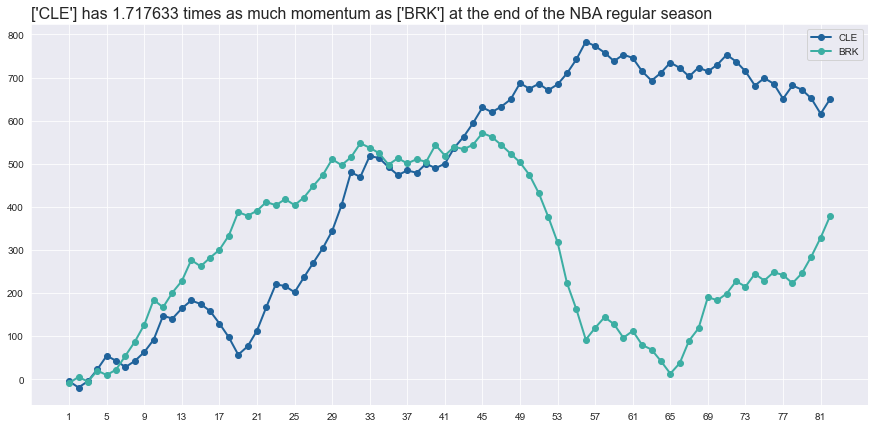

In [872]:
momentum_visualizer('CLE', 'BRK')

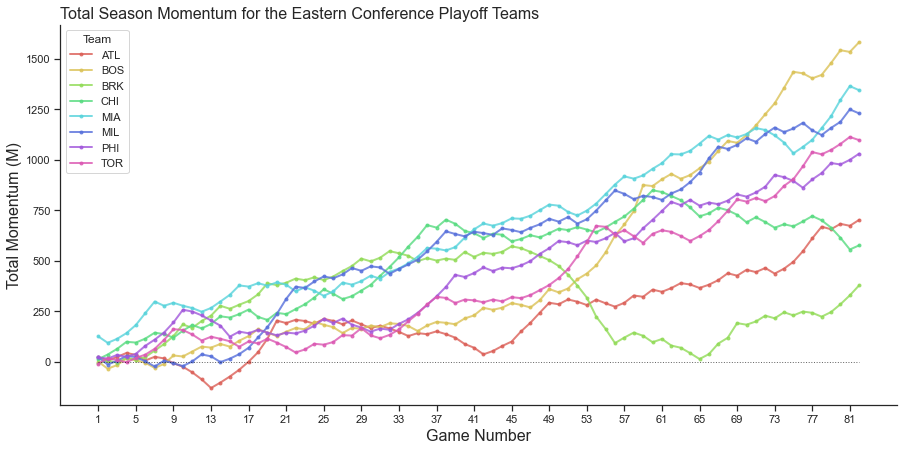

In [909]:
ec_playoff = ['MIA', 'BOS', 'MIL', 'PHI', 'TOR', 'CHI', 'BRK', 'ATL']
wc_playoff = ['PHO', 'MEM', 'GSW', 'DAL', 'UTA', 'DEN', 'MIN', 'NOP']

ec_playin = ['BRK', 'CLE', 'ATL', 'CHO']
wc_playin = ['LAC', 'MIN', 'NOP', 'SAS']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.set_palette(sns.color_palette('hls', 8))

data.loc[data.index.get_level_values('Team').isin(ec_playoff), 'M'].reset_index().pivot_table(
    columns = 'Team'
    , values = 'M'
    , index = 'Game'
    , aggfunc = np.sum
).plot(figsize = (15, 7), linewidth = 2, alpha = .8, marker = '.')

plt.hlines(y = 0, xmin = 1, xmax = 82, color = 'black', linestyle = ':', linewidth = 1, alpha = .6)

plt.xticks(ticks = np.arange(1, 83, step = 4), labels = np.arange(1, 83, step = 4))


plt.xlabel('Game Number', fontdict = {'fontsize' : 16, 'font' : 'Arial'})
plt.ylabel('Total Momentum (M)', fontdict = {'fontsize' : 16, 'font' : 'Arial'})
plt.title('Total Season Momentum for the Eastern Conference Playoff Teams', fontdict = {'fontsize' : 16, 'font' : 'Arial'}, loc = 'left')

plt.savefig('ec_playoff_momentum.png', dpi = 300)
# plt.savefig('wc_playoff_momentum.png', dpi = 300)

plt.show()

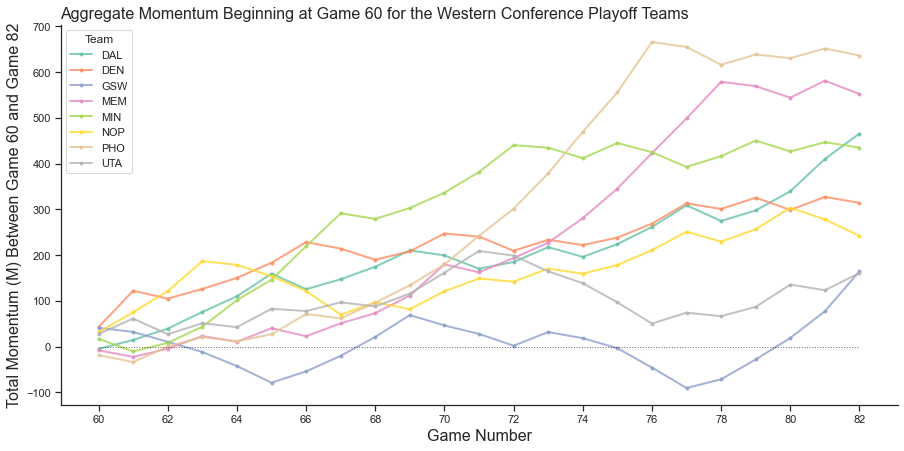

In [911]:
#----------------------------------------------------------------------------------------------------------#
#--- Momentum Plot for Final 22 Games                                                                   ---#
#----------------------------------------------------------------------------------------------------------#

ec_playoff = ['MIA', 'BOS', 'MIL', 'PHI', 'TOR', 'CHI', 'BRK', 'ATL']
wc_playoff = ['PHO', 'MEM', 'GSW', 'DAL', 'UTA', 'DEN', 'MIN', 'NOP']

ec_playin = ['BRK', 'CLE', 'ATL', 'CHO']
wc_playin = ['LAC', 'MIN', 'NOP', 'SAS']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
# sns.set_palette(sns.color_palette('hls', 8))
sns.set_palette('Set2')

data.loc[(data.index.get_level_values('Team').isin(wc_playoff)) & 
            (data.index.get_level_values('Game') >= 60), 
            'm'].reset_index().pivot_table(
            columns = 'Team'
            , values = 'm'
            , index = 'Game'
            , aggfunc = np.sum
        ).cumsum().plot(figsize = (15, 7), linewidth = 2, alpha = .8, marker = '.')

plt.hlines(y = 0, xmin = 60, xmax = 82, color = 'black', linestyle = ':', linewidth = 1, alpha = .6)

plt.xticks(ticks = np.arange(60, 83, step = 2), labels = np.arange(60, 83, step = 2))


plt.xlabel('Game Number', fontdict = {'fontsize' : 16, 'font' : 'Arial'})
plt.ylabel('Total Momentum (M) Between Game 60 and Game 82', fontdict = {'fontsize' : 16, 'font' : 'Arial'})
plt.title('Aggregate Momentum Beginning at Game 60 for the Western Conference Playoff Teams', fontdict = {'fontsize' : 16, 'font' : 'Arial'}, loc = 'left')

# plt.savefig('ec_playoff_momentum_game_sixty.png', dpi = 300)
plt.savefig('wc_playoff_momentum_game_sixty.png', dpi = 300)

plt.show()

In [818]:
def aggregate_momentum_visualizer(option, df = data, var = 'M'):

    ec_playoff = ['MIA', 'BOS', 'MIL', 'PHI', 'TOR', 'CHI', 'BRK', 'ATL']
    wc_playoff = ['PHO', 'MEM', 'GSW', 'DAL', 'UTA', 'DEN', 'MIN', 'NOP']

    ec_playin = ['BRK', 'CLE', 'ATL', 'CHO']
    wc_playin = ['LAC', 'MIN', 'NOP', 'SAS']

    if option == 'ec_playoff':
        x = ec_playoff

        data.loc[data.index.get_level_values('Team').isin(x), 'M'].reset_index().pivot_table(
        columns = 'Team'
        , values = 'M'
        , index = 'Game'
        , aggfunc = np.sum
        ).plot(figsize = (15, 7), linestyle = ':')

        plt.hlines(y = 0, xmin = 1, xmax = 82, color = 'black', linewidth = 2, alpha = .6)

    elif option == 'wc_playoff':
        x = wc_playoff

        data.loc[data.index.get_level_values('Team').isin(x), 'M'].reset_index().pivot_table(
        columns = 'Team'
        , values = 'M'
        , index = 'Game'
        , aggfunc = np.sum
        ).plot(figsize = (15, 7), linestyle = ':')

        plt.hlines(y = 0, xmin = 1, xmax = 82, color = 'black', linewidth = 2, alpha = .6)

    elif option == 'ec_playin':
        x = ec_playin

        data.loc[data.index.get_level_values('Team').isin(x), 'M'].reset_index().pivot_table(
        columns = 'Team'
        , values = 'M'
        , index = 'Game'
        , aggfunc = np.sum
        ).plot(figsize = (15, 7), linestyle = ':')

        plt.hlines(y = 0, xmin = 1, xmax = 82, color = 'black', linewidth = 2, alpha = .6)


    else:
        x = wc_playin

        data.loc[data.index.get_level_values('Team').isin(x), 'M'].reset_index().pivot_table(
        columns = 'Team'
        , values = 'M'
        , index = 'Game'
        , aggfunc = np.sum
        ).plot(figsize = (15, 7), linestyle = ':')

        plt.hlines(y = 0, xmin = 1, xmax = 82, color = 'black', linewidth = 2, alpha = .6)        

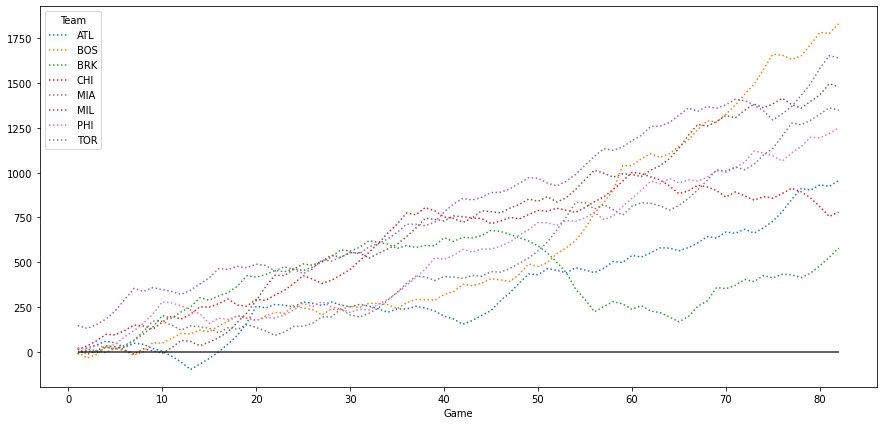

In [819]:
aggregate_momentum_visualizer('ec_playoff')

In [ ]:
   
ec_playoff = ['MIA', 'BOS', 'MIL', 'PHI', 'TOR', 'CHI', 'BRK', 'ATL']
wc_playoff = ['PHO', 'MEM', 'GSW', 'DAL', 'UTA', 'DEN', 'MIN', 'NOP']

ec_playin = ['BRK', 'CLE', 'ATL', 'CHO']
wc_playin = ['LAC', 'MIN', 'NOP', 'SAS']

data.loc[data.index.get_level_values('Team').isin(ec_playin), 'M'].reset_index().pivot_table(
        columns = 'Team'
        , values = 'M'
        , index = 'Game'
        , aggfunc = np.sum
).plot(figsize = (15, 7), linestyle = ':')

plt.hlines(y = 0, xmin = 1, xmax = 82, color = 'black', linewidth = 2, alpha = .6)

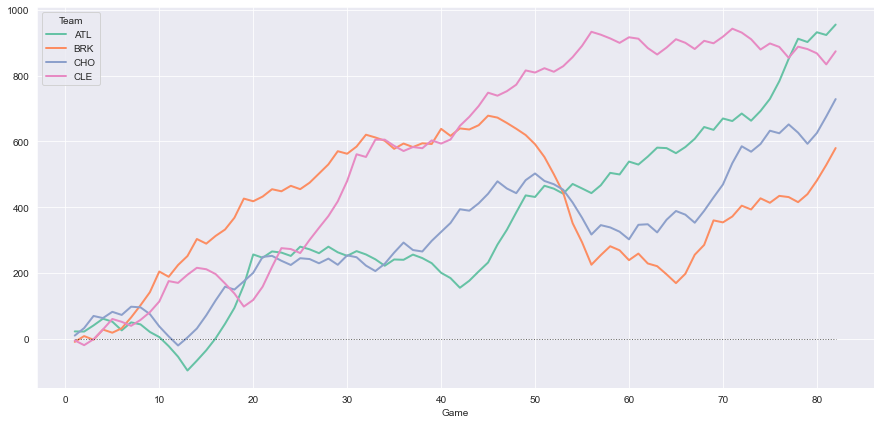

In [826]:
import seaborn as sns

sns.set_palette('Set2')

sns.set_style('darkgrid')
# sns.despine()

ec_playoff = ['MIA', 'BOS', 'MIL', 'PHI', 'TOR', 'CHI', 'BRK', 'ATL']
wc_playoff = ['PHO', 'MEM', 'GSW', 'DAL', 'UTA', 'DEN', 'MIN', 'NOP']

ec_playin = ['BRK', 'CLE', 'ATL', 'CHO']
wc_playin = ['LAC', 'MIN', 'NOP', 'SAS']

data.loc[data.index.get_level_values('Team').isin(ec_playin), 'M'].reset_index().pivot_table(
        columns = 'Team'
        , values = 'M'
        , index = 'Game'
        , aggfunc = np.sum
).plot(figsize = (15, 7), linewidth = 2)

plt.hlines(y = 0, xmin = 1, xmax = 82, color = 'black', linestyle = ':', linewidth = 1, alpha = .6)

plt.show()

In [ ]:
#-- Win Loss Parameter Visualization --#

wldf = pd.DataFrame(pd.Series(np.arange(1, 83, 1)))
wldf.columns = ['GAME']

wldf['WINPER'] = wldf['GAME'] / 82
wldf['LP1'] = np.exp(1 - wldf.GAME / 82) ** 1.5 
wldf['WP1'] = np.log(1 - np.minimum(wldf.GAME / 82, .99)) * -1 + 1
wldf['LP2'] = np.log( 1 / wldf.WINPER ) + 1 
wldf['WP2'] = np.log( 1 / (1 - np.minimum(wldf.WINPER, .99) ) ) + 1

#-- Visualize Impacts
plt.figure(figsize = (25 , 12))


plt.plot(wldf.WINPER, wldf.LP2, color = color_palette[1])
plt.plot(wldf.WINPER, wldf.WP2, color = color_palette[2])

plt.show()


In [787]:
mcols = ['opp_win_pct_pkey','Theta', 'Delta_P', 'Zeta', 'Gamma', 'Omega', 'Lambda', 'm', 'M']
data.loc[data.index.get_level_values('Team') == 'UTA', mcols].iloc[15:40]

,,opp_win_pct_pkey,Theta,Delta_P,Zeta,Gamma,Omega,Lambda,m,M
Game,Team,,,,,,,,,
16,UTA,16_SAC,5.490159,8.874037,3,6.619341,1.470004,1.25,45.937949,340.385561
17,UTA,17_MEM,5.300865,-0.492941,-1,6.638444,1.635989,1.25,-0.432345,339.953216
18,UTA,18_OKC,4.693233,2.956239,1,6.653687,1.405465,1.25,19.068173,359.021389
19,UTA,19_NOP,4.631646,-0.492678,-1,6.665469,2.845827,1.25,3.446951,362.468340
20,UTA,20_NOP,6.827887,10.835190,1,6.674139,1.223144,1.00,28.278618,390.746958
21,UTA,21_POR,5.689286,10.832962,2,6.680004,1.646627,1.00,40.565990,431.312947
22,UTA,22_BOS,7.571317,3.446386,3,6.683340,1.788457,1.00,39.754713,471.067660
23,UTA,23_CLE,5.857074,0.492294,4,6.684399,1.832909,1.25,45.059810,516.127470
24,UTA,24_MIN,6.823118,15.749685,5,6.539354,1.613104,1.25,77.283254,593.410724


In [800]:
#-- Smoothing DataFrame --#
smoothing_1 = (((1/3) * games_vector ** 3) - ((64/2) * games_vector ** 2) + (943 * games_vector))
smoothing_6 = (-1 * np.cos(2 * np.pi * ((np.absolute(games_vector - 41)/41)))) + 5.85

smoothing_df = pd.DataFrame(smoothing_6)
smoothing_df.columns = ['PARAMETER_1']

smoothing_df['GAME'] = np.arange(1, 83, step = 1)

smoothing_df['PARAMETER_2'] = np.log(smoothing_1) - 2.4

smoothing_df['PARAMETER_3'] = np.sqrt( smoothing_df['PARAMETER_2'] ** (1.2 + (smoothing_df['GAME'] / 82)) )

smoothing_df['GAMMA'] = np.nan

smoothing_df.loc[(smoothing_df['GAME'] < 24), 'GAMMA'] = smoothing_df.loc[(smoothing_df['GAME'] < 24), 'PARAMETER_2']
smoothing_df.loc[(smoothing_df['GAME'] >= 24) &
                 (smoothing_df['GAME'] <= 61), 'GAMMA'] = smoothing_df.loc[(smoothing_df['GAME'] >= 24) &
                                                                           (smoothing_df['GAME'] <= 61), 'PARAMETER_1']
smoothing_df.loc[(smoothing_df['GAME'] > 61), 'GAMMA'] = smoothing_df.loc[(smoothing_df['GAME'] > 61), 'PARAMETER_3']



smoothing_df.set_index('GAME', inplace = True)

smoothing_df.tail()

,PARAMETER_1,PARAMETER_2,PARAMETER_3,GAMMA
GAME,,,,
78,5.032071,8.120024,9.513245,9.513245
79,4.953834,8.174679,9.705686,9.705686
80,4.896604,8.228779,9.901622,9.901622
81,4.861720,8.282308,10.101085,10.101085
82,4.850000,8.335251,10.304112,10.304112


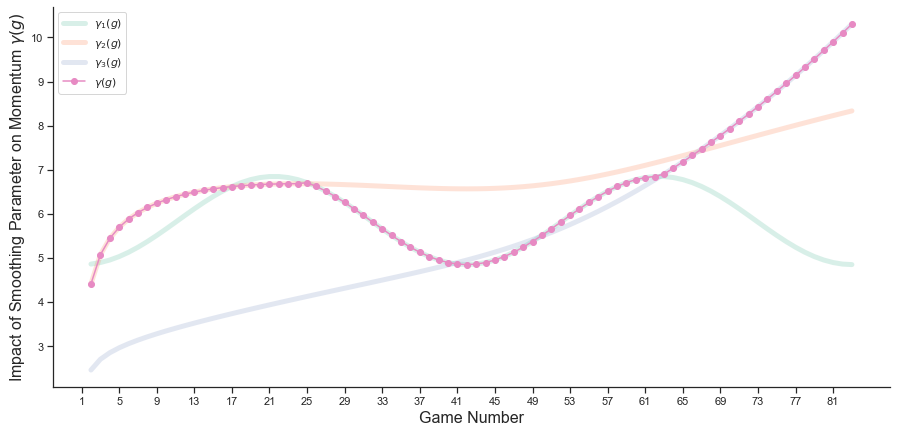

In [926]:
#-- Visualize Smoothing Parameter --#

plt.figure(figsize = (15, 7))

color_palette = ['#173F5F', '#20639B', '#3CAEA3', '#F6D55C', '#ED553B']
font_params = {'fontsize' : 16, 'font' : 'Arial'}

plt.plot(smoothing_df.PARAMETER_1
            #, linestyle = ':'
            , alpha = .25
            #, color = color_palette[4]
            , linewidth = 5)

plt.plot(smoothing_df.PARAMETER_2
            #, linestyle = ':'
            , alpha = .25
            #, color = color_palette[2]
            , linewidth = 5)

plt.plot(smoothing_df.PARAMETER_3
            #, linestyle = ':'
            , alpha = .25
            #, color = color_palette[3]
            , linewidth = 5)

plt.plot(smoothing_df.GAMMA
            #, color = color_palette[0]
            , marker = 'o')

plt.xticks(ticks = np.arange(0, 83, step = 4), labels = np.arange(1, 83, step = 4))

plt.xlabel('Game Number'
            , font_params)
plt.ylabel('Impact of Smoothing Parameter on Momentum $\gamma(g)$'
            , fontdict = font_params)
plt.legend(['$\gamma_{1}(g)$', '$\gamma_{2}(g)$', '$\gamma_{3}(g)$', '$\gamma (g)$' ])

plt.savefig('gamma_visualized.png', dpi = 300)

plt.show()


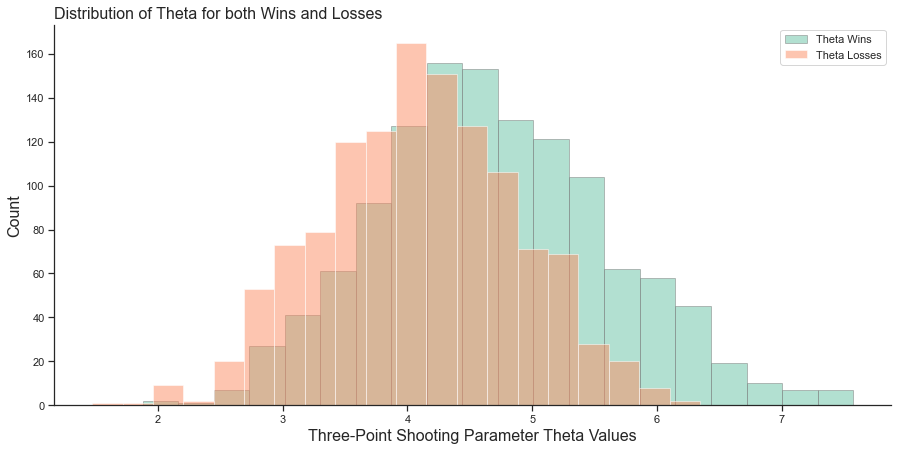

In [923]:
#----------------------------------------------------#
#                 Visualize Theta                    #
#----------------------------------------------------#

plt.figure(figsize = (15, 7))

plt.hist(data.loc[data['win_binary'] == 1, 'Theta'], alpha = .5, ec = 'grey', bins = 20)
plt.hist(data.loc[data['win_binary'] == 0, 'Theta'], alpha = .5, bins = 20)

plt.legend(['Theta Wins', 'Theta Losses'])

plt.xlabel('Three-Point Shooting Parameter Theta Values', fontdict = {'fontsize' : 16, 'font' : 'Arial'})
plt.ylabel('Count', fontdict = {'fontsize' : 16, 'font' : 'Arial'})
plt.title('Distribution of Theta for both Wins and Losses', fontdict = {'fontsize' : 16, 'font' : 'Arial'}, loc = 'left')

plt.savefig('theta_distribution.png', dpi = 300)

plt.show()